## K-means

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class KMeansImageSegmentation:
    def __init__(self, image_path):
        self.image_path = image_path
        self.img = plt.imread(image_path)
        self.row = self.img.shape[0]
        self.col = self.img.shape[1]

    def kmeans(self, data, iter, k):
        data = data.reshape(-1, 3)
        data = np.column_stack((data, np.ones(self.row * self.col)))

        # 1. 随机初始化聚类中心
        cluster_center = data[np.random.choice(self.row * self.col, k)]

        # 2. 迭代的K均值算法
        for i in range(iter):
            # 2.1 计算距离
            distances = [[] for i in range(k)]
            for j in range(k):
                distances[j] = np.sqrt(np.sum((data[:, :3] - cluster_center[j, :3]) ** 2, axis=1))

            # 2.2 分配到最近的聚类中心
            data[:, 3] = np.argmin(distances, axis=0)

            # 3. 更新聚类中心
            for j in range(k):
                cluster_center[j] = np.mean(data[data[:, 3] == j], axis=0)

        return data[:, 3]

    def segment_image(self, iter=100, k=2):
        segmented_image = self.kmeans(self.img, iter, k)
        segmented_image = segmented_image.reshape(self.row, self.col)
        return segmented_image

    def display_original_and_segmented(self, iter=100, k=5):
        plt.subplot(121)
        plt.imshow(self.img)
        plt.title('Original Image')

        segmented_image = self.segment_image(iter, k)

        plt.subplot(122)
        plt.imshow(segmented_image, cmap='gray')
        plt.title('Segmented Image (K-means)')

        plt.show()

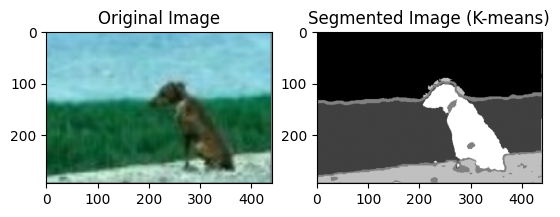

In [4]:
if __name__ == "__main__":
    image_segmenter = KMeansImageSegmentation(r'D:\作业\机器学习\45_2200170289_罗定友_06\dog.png')
    image_segmenter.display_original_and_segmented()

## FCM

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [6]:
class FCMImageSegmentation:
    def __init__(self, image_path, clusters=3, m=2.0, max_iters=100):
        self.image_path = image_path
        self.clusters = clusters
        self.m = m
        self.max_iters = max_iters

    def initialize_membership(self, X):
        # 初始化隶属度矩阵
        U = np.random.dirichlet(np.ones(self.clusters), size=X.shape[0])
        return U

    def update_centroids(self, X, U):
        # 更新质心
        um = U ** self.m
        centroids = (um.T @ X) / um.sum(axis=0)[:, None]
        return centroids

    def update_membership(self, X, centroids):
        # 更新隶属度矩阵
        dist = np.linalg.norm(X[:, None] - centroids, axis=2)
        dist = np.fmax(dist, np.finfo(np.float64).eps)  # 避免除以零
        inv_dist = 1.0 / dist
        power = 2.0 / (self.m - 1)
        U_new = inv_dist ** power / (inv_dist ** power).sum(axis=1, keepdims=True)
        return U_new

    def has_converged(self, U, U_new, tol=1e-4):
        # 检查隶属度矩阵是否收敛
        return np.linalg.norm(U - U_new) < tol

    def fcm(self, image):
        # FCM聚类算法
        pixels = image.reshape(-1, 3)
        U = self.initialize_membership(pixels)

        for _ in range(self.max_iters):
            centroids = self.update_centroids(pixels, U)
            U_new = self.update_membership(pixels, centroids)
            if self.has_converged(U, U_new):
                break
            U = U_new

        clusters = np.argmax(U, axis=1)
        segmented_image = clusters.reshape(image.shape[:2])
        return segmented_image

    def display_segmented_image(self):
        # 加载图像并进行FCM分割显示
        image = cv2.imread(self.image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        segmented_image = self.fcm(image)

        # 显示原始图像和分割后的图像
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image)
        ax[0].set_title('Original Image')
        ax[1].imshow(segmented_image, cmap='gray')
        ax[1].set_title('Segmented Image(FCM)')
        plt.show()

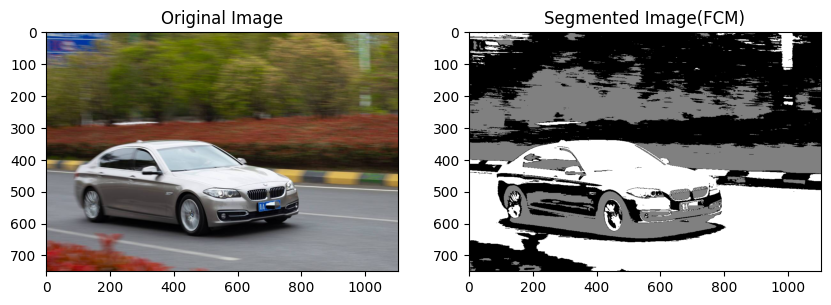

In [7]:
if __name__ == "__main__":
    image_segmenter = FCMImageSegmentation("D:\Download\car.jpg")
    image_segmenter.display_segmented_image()